<br>
<br>
<br>
<font size=6>Предсказание оттока пользователей</font>
<br>
<br>
<br>
Это соревнование является домашним заданием к 3 модулю продвинутого потока DLS.<br>
Вам предстоит научиться моделировать отток клиентов телеком компании.<br>
Эта задача очень важна на практике и алгоритмы для ее решения используются в реальных телеком компаниях, <br>
ведь если мы знаем, что клиент собирается уйти от нас, то мы попытаемся удержать его, предложив какие-то бонусы.<br>
<br>
<br>
<br>
Ссылка на <a href='https://www.kaggle.com/competitions/advanced-dls-spring-2021/data'>датасет.</a>
<br><br>

In [204]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, roc_curve, accuracy_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.model_selection import GridSearchCV


warnings.filterwarnings('ignore')

<br>
<font size=6>Эпизод Ⅰ</font><br>
<br>
<font size=5>Исследование</font>
<hr>

<br>
<font size=4><b>Загрузка данных</b></font>
<br><br>

In [205]:
data_train = pd.read_csv('data/churn_dataset/train.csv')
print(f'Objects: {data_train.shape[0]}')
print(f'Features: {data_train.shape[1]}')
data_train.head()

Objects: 5282
Features: 20


,ClientPeriod,MonthlySpending,TotalSpent,Sex,IsSeniorCitizen,HasPartner,HasChild,HasPhoneService,HasMultiplePhoneNumbers,HasInternetService,HasOnlineSecurityService,HasOnlineBackup,HasDeviceProtection,HasTechSupportAccess,HasOnlineTV,HasMovieSubscription,HasContractPhone,IsBillingPaperless,PaymentMethod,Churn
0,55,19.50,1026.35,Male,0,Yes,Yes,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,One year,No,Mailed check,0
1,72,25.85,1872.2,Male,0,Yes,No,Yes,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Credit card (automatic),0
2,1,75.90,75.9,Male,0,No,No,Yes,No,Fiber optic,No,No,No,Yes,No,No,Month-to-month,Yes,Electronic check,1
3,32,79.30,2570,Female,1,Yes,No,Yes,Yes,Fiber optic,No,No,Yes,No,No,No,Month-to-month,No,Mailed check,0
4,60,115.25,6758.45,Female,0,Yes,Yes,Yes,Yes,Fiber optic,Yes,Yes,Yes,Yes,Yes,Yes,Two year,No,Credit card (automatic),0


In [206]:
data_test = pd.read_csv('data/churn_dataset/test.csv')
print(f'Objects: {data_test.shape[0]}')
print(f'Features: {data_test.shape[1]}')
data_test.head()

Objects: 1761
Features: 19


,ClientPeriod,MonthlySpending,TotalSpent,Sex,IsSeniorCitizen,HasPartner,HasChild,HasPhoneService,HasMultiplePhoneNumbers,HasInternetService,HasOnlineSecurityService,HasOnlineBackup,HasDeviceProtection,HasTechSupportAccess,HasOnlineTV,HasMovieSubscription,HasContractPhone,IsBillingPaperless,PaymentMethod
0,42,56.10,2386.85,Male,0,Yes,No,Yes,Yes,DSL,Yes,No,No,No,No,No,One year,No,Credit card (automatic)
1,29,98.50,3004.15,Male,1,Yes,No,Yes,Yes,Fiber optic,No,No,Yes,No,Yes,Yes,Month-to-month,Yes,Electronic check
2,9,76.25,684.85,Male,0,No,No,Yes,Yes,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check
3,67,74.00,4868.4,Female,0,Yes,Yes,Yes,Yes,DSL,Yes,Yes,No,Yes,Yes,No,Two year,No,Credit card (automatic)
4,71,20.10,1389.6,Female,0,Yes,Yes,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Bank transfer (automatic)


<br>
<font size=4><b>Exploratory data analysis</b></font>
<br><br>

<br>
Начнем с изучения признаков.<br>
Признаки довольно простые и понять какие в них значения несложно, но вопросы возникают к <b>HasInternetService</b>, <b>HasContractPhone</b>, <b>PaymentMethod</b>.
<br><br>

In [207]:
def get_series_procent(count_: pd.Series, value_counts: pd.Series) -> pd.Series:
    """ Рассчитает процент для каждого значения в серии """
    procent_list = [value/count_ for value in val_counts]
    procent_series = pd.Series(data=procent_list, index=val_counts.index)
    return procent_series

In [208]:
features_question = ['HasInternetService', 'HasContractPhone', 'PaymentMethod']

for feature in features_question:
    count_ = data_train[feature].count()
    val_counts = data_train[feature].value_counts()
    procent_series = get_series_procent(count_, val_counts)
    features_df = pd.DataFrame(
        data={
            'value_counts': val_counts,
            'procent': procent_series},
        index=val_counts.index)
    features_df.index.rename(feature, inplace=True)
    print(f'{features_df} \n\n')

                    value_counts   procent
HasInternetService                        
Fiber optic                 2341  0.443203
DSL                         1800  0.340780
No                          1141  0.216017 


                  value_counts   procent
HasContractPhone                        
Month-to-month            2920  0.552821
Two year                  1280  0.242332
One year                  1082  0.204847 


                           value_counts   procent
PaymentMethod                                    
Electronic check                   1786  0.338129
Mailed check                       1194  0.226051
Bank transfer (automatic)          1159  0.219424
Credit card (automatic)            1143  0.216395 




Все значения более-менее сбалансированы.<br>
<b>HasContractPhone</b> будем кодировать с помощью <b>Ordinal Encoding</b>, остальные категориальные признаки пойдут через <b>One-Hot Encoding</b>.

<br>
Проверим данные рандомного клиента
<br><br>

In [209]:
data_train.iloc[np.random.randint(data_train.shape[0])]

ClientPeriod                               1
MonthlySpending                        75.35
TotalSpent                             75.35
Sex                                     Male
IsSeniorCitizen                            1
HasPartner                                No
HasChild                                  No
HasPhoneService                          Yes
HasMultiplePhoneNumbers                  Yes
HasInternetService               Fiber optic
HasOnlineSecurityService                  No
HasOnlineBackup                           No
HasDeviceProtection                       No
HasTechSupportAccess                      No
HasOnlineTV                               No
HasMovieSubscription                      No
HasContractPhone              Month-to-month
IsBillingPaperless                       Yes
PaymentMethod               Electronic check
Churn                                      1
Name: 1036, dtype: object

<br>
Посмотрим какой тип данных принимает каждый признак
<br><br>

In [210]:
data_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5282 entries, 0 to 5281
Data columns (total 20 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   ClientPeriod              5282 non-null   int64  
 1   MonthlySpending           5282 non-null   float64
 2   TotalSpent                5282 non-null   object 
 3   Sex                       5282 non-null   object 
 4   IsSeniorCitizen           5282 non-null   int64  
 5   HasPartner                5282 non-null   object 
 6   HasChild                  5282 non-null   object 
 7   HasPhoneService           5282 non-null   object 
 8   HasMultiplePhoneNumbers   5282 non-null   object 
 9   HasInternetService        5282 non-null   object 
 10  HasOnlineSecurityService  5282 non-null   object 
 11  HasOnlineBackup           5282 non-null   object 
 12  HasDeviceProtection       5282 non-null   object 
 13  HasTechSupportAccess      5282 non-null   object 
 14  HasOnlin

<b>TotalSpent</b> имеет тип данных 'object', но если посмотреть на датасет,<br>
то получается далеко не 'object' - это заявка на пропуск в данных.

<br>
<font size=3><b>Поиск пропусков</b></font>
<br><br>

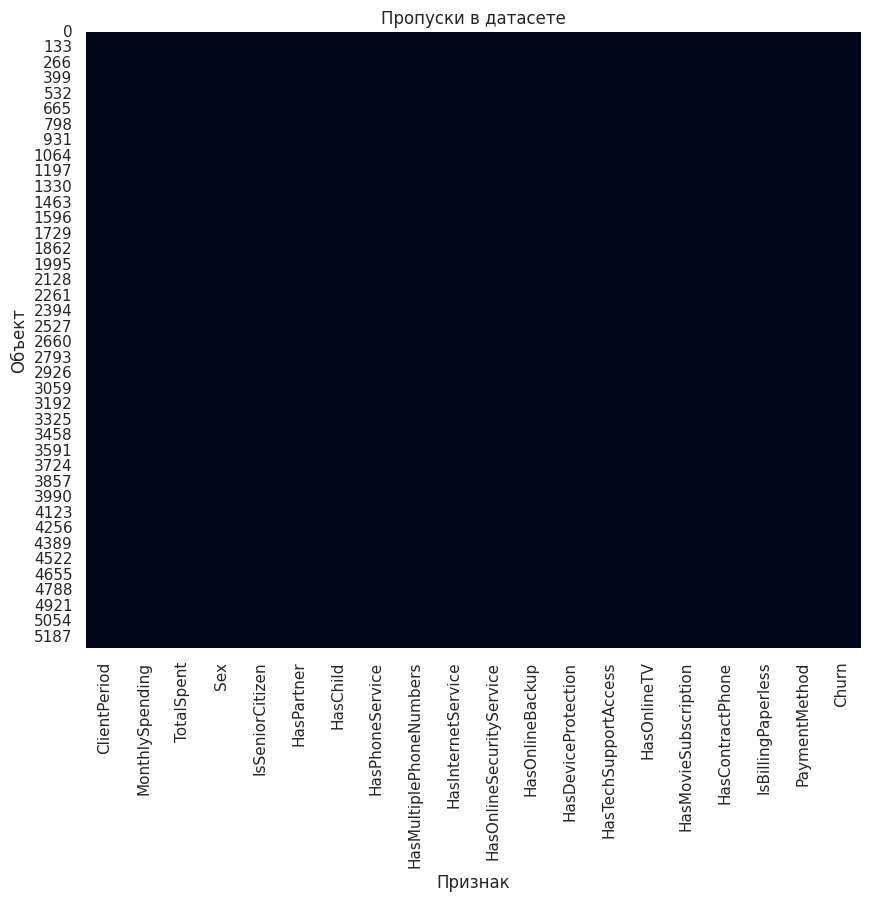

Кол-во пропусков в каждом признаке:
ClientPeriod                0
MonthlySpending             0
TotalSpent                  0
Sex                         0
IsSeniorCitizen             0
HasPartner                  0
HasChild                    0
HasPhoneService             0
HasMultiplePhoneNumbers     0
HasInternetService          0
HasOnlineSecurityService    0
HasOnlineBackup             0
HasDeviceProtection         0
HasTechSupportAccess        0
HasOnlineTV                 0
HasMovieSubscription        0
HasContractPhone            0
IsBillingPaperless          0
PaymentMethod               0
Churn                       0
dtype: int64


In [211]:
plt.figure(figsize=(10, 8))
sns.heatmap(data_train.isnull(), cbar=False)
plt.title('Пропуски в датасете')
plt.xlabel('Признак')
plt.ylabel('Объект')
plt.show()

print('Кол-во пропусков в каждом признаке:')
print(data_train.isnull().sum())

Heatmap и количество пропусков говорят, что нет пропусков в виде NaN.

In [212]:
categorical_columns = [col for col in data_train
                       if data_train[col].dtypes == 'object']

for column in categorical_columns:
    print('-'*5, column, '-'*5)
    print(data_train[column].value_counts())
    print('\n')

----- TotalSpent -----
           9
20.2       9
19.75      8
20.05      6
19.65      6
          ..
41.85      1
4326.25    1
950.2      1
4264       1
1375.6     1
Name: TotalSpent, Length: 4978, dtype: int64


----- Sex -----
Male      2655
Female    2627
Name: Sex, dtype: int64


----- HasPartner -----
No     2705
Yes    2577
Name: HasPartner, dtype: int64


----- HasChild -----
No     3676
Yes    1606
Name: HasChild, dtype: int64


----- HasPhoneService -----
Yes    4761
No      521
Name: HasPhoneService, dtype: int64


----- HasMultiplePhoneNumbers -----
No                  2511
Yes                 2250
No phone service     521
Name: HasMultiplePhoneNumbers, dtype: int64


----- HasInternetService -----
Fiber optic    2341
DSL            1800
No             1141
Name: HasInternetService, dtype: int64


----- HasOnlineSecurityService -----
No                     2612
Yes                    1529
No internet service    1141
Name: HasOnlineSecurityService, dtype: int64


----- HasOnl

У TotalSpent есть значение <b>пробела</b> вместо числа, поэтому и получился object, исправим это

In [213]:
data_train.TotalSpent.replace(' ', np.nan, inplace=True)
data_train.TotalSpent = data_train.TotalSpent.astype('float64')
data_train = data_train.dropna()

Теперь пропусков в обучающем датасете нет.

<br>
<b>Посмотрим как распределены значения числовых признаков</b>
<br><br>

In [214]:
numerical_columns = [col for col in data_train
                     if data_train[col].dtypes in ['int64', 'float64']]

In [215]:
def get_hist(name_feature: str, size1: int, size2: int) -> None:
    """Фукнция строит hist график по имени признака"""
    fig, ax = plt.subplots(figsize=(size1, size2))
    ax.set_title(name_feature)
    sns.set_theme(style='whitegrid', palette='pastel')
    sns.countplot(data=data_train, x=data_train[name_feature], hue='Churn')

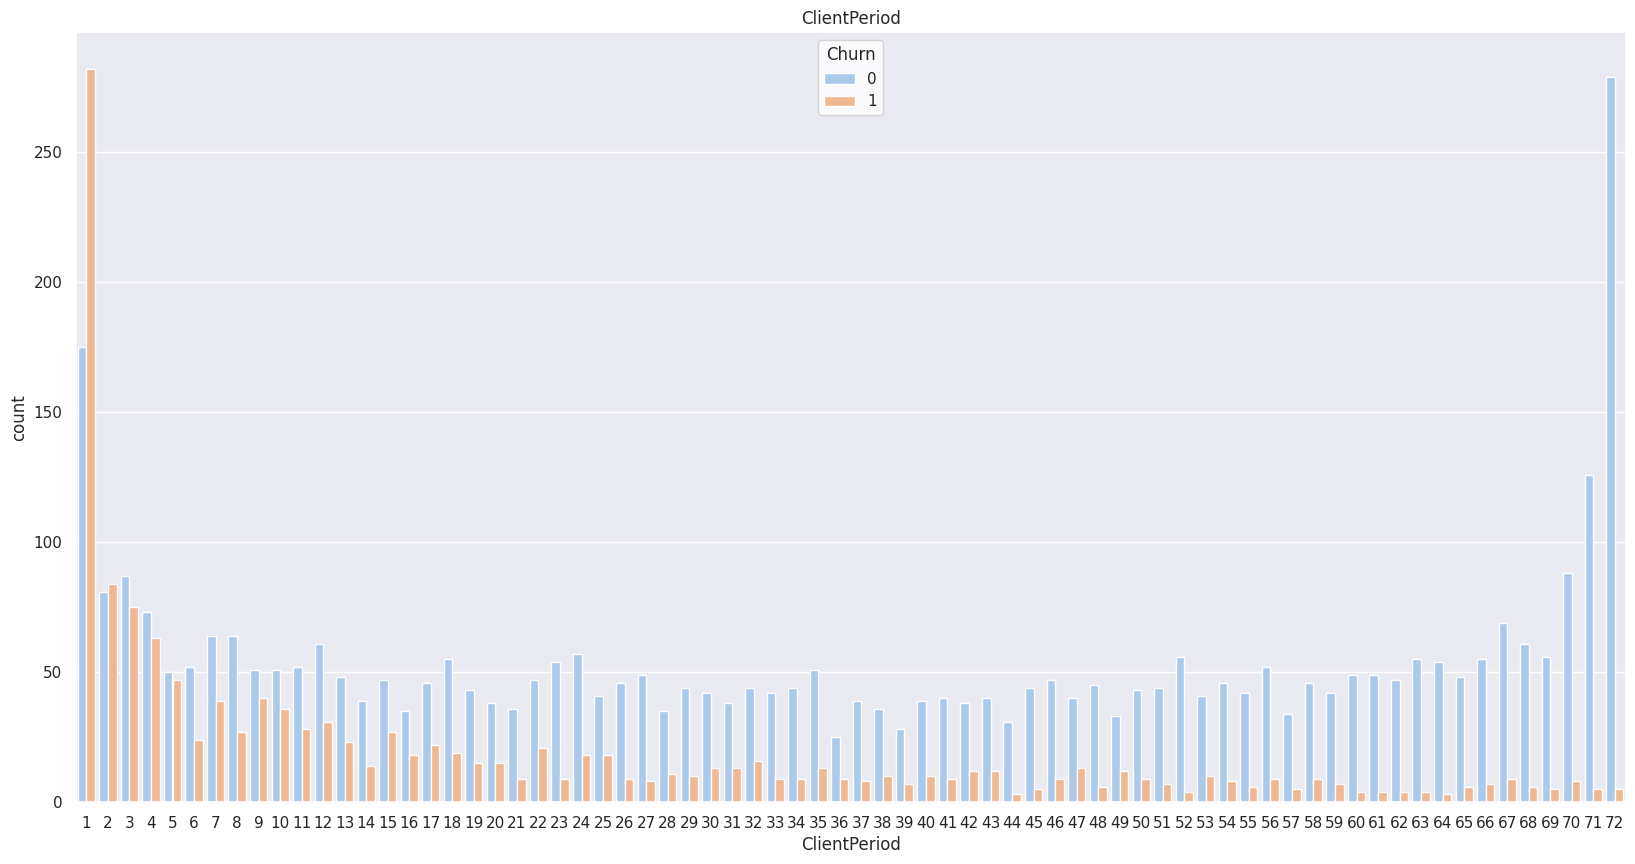

In [216]:
get_hist(name_feature='ClientPeriod', size1=20, size2=10)

In [217]:
first_one = data_train.loc[(data_train["ClientPeriod"] == 1) & (data_train['Churn'] == 1)].shape[0]
first_zero = data_train.loc[(data_train["ClientPeriod"] == 1) & (data_train['Churn'] == 0)].shape[0]

print(f'Отказ в первый день: {first_one}')
print(f'Соглашение в первый день: {first_zero}')

Отказ в первый день: 282
Соглашение в первый день: 175


На графике видно, что большинство людей уходят в первые дни пользования и это нормально. Человек устанавливает приложение и решает оставить его или нет.<br>
После примерно 15 дней использования шанс, что клиент откажется от услуг падает. <br>
В первый день вероятность отказа клиента максимальная.<br>

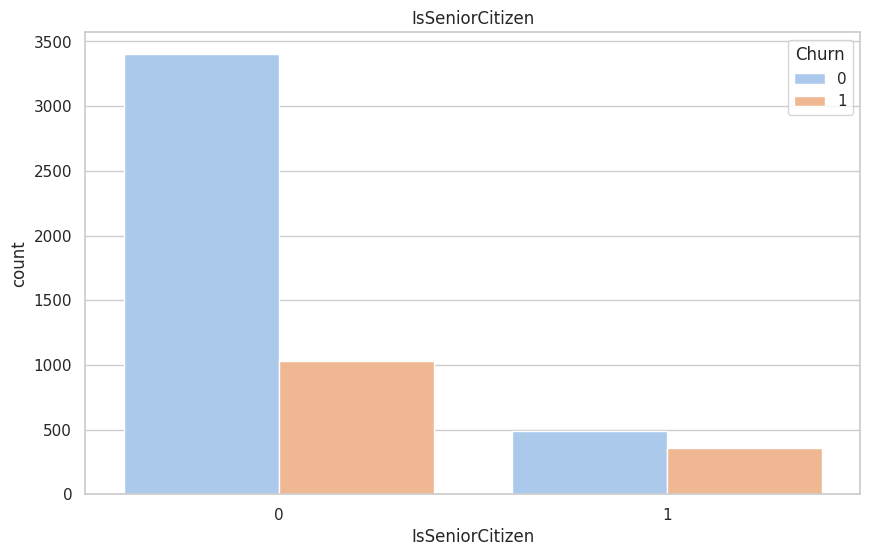

In [218]:
get_hist(name_feature='IsSeniorCitizen', size1=10, size2=6)

Пожилых людей гораздо меньше, чем молодых - с этим тоже все ок.

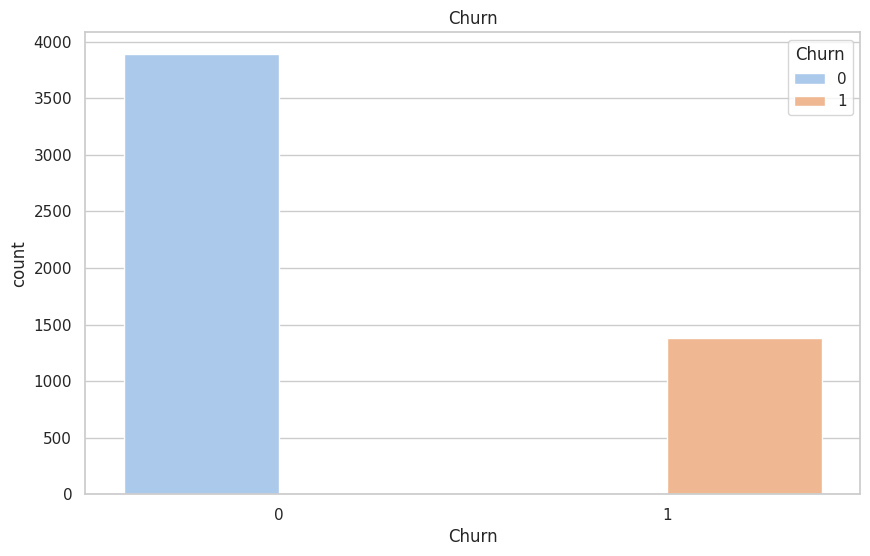

In [219]:
get_hist(name_feature='Churn', size1=10, size2=6)

In [220]:
churn_zero = data_train[data_train.Churn == 0].shape[0]
churn_one = data_train[data_train.Churn == 1].shape[0]
print(f'Класс 0: {churn_zero}')
print(f'Класс 1: {churn_one}')
print(f'Процент класса 1: {round(churn_one/data_train.shape[0] * 100)}%')

Класс 0: 3889
Класс 1: 1384
Процент класса 1: 26%


Один из главных графиков - <b>распределение целевой переменной</b>.<br>
Класс 0 превосходит в количестве класс 1, разница = 2505. <b>Целевая переменная несбалансированная</b>.<br>
Проблему с балансом мы решим на этапе предобработки данных.
<br><br>
<b>Вывод:</b> 26% клиентов отказываются от услуг компании, при этом большинство в первый же день, такой показатель можно считать плохим. Большинство клиентов - "не пожилые люди".

<br>
<b>Посмотрим как распределены значения категориальных признаков.</b>
<br><br>

In [221]:
categorical_columns = [col for col in data_train
                       if data_train[col].dtypes == 'object']

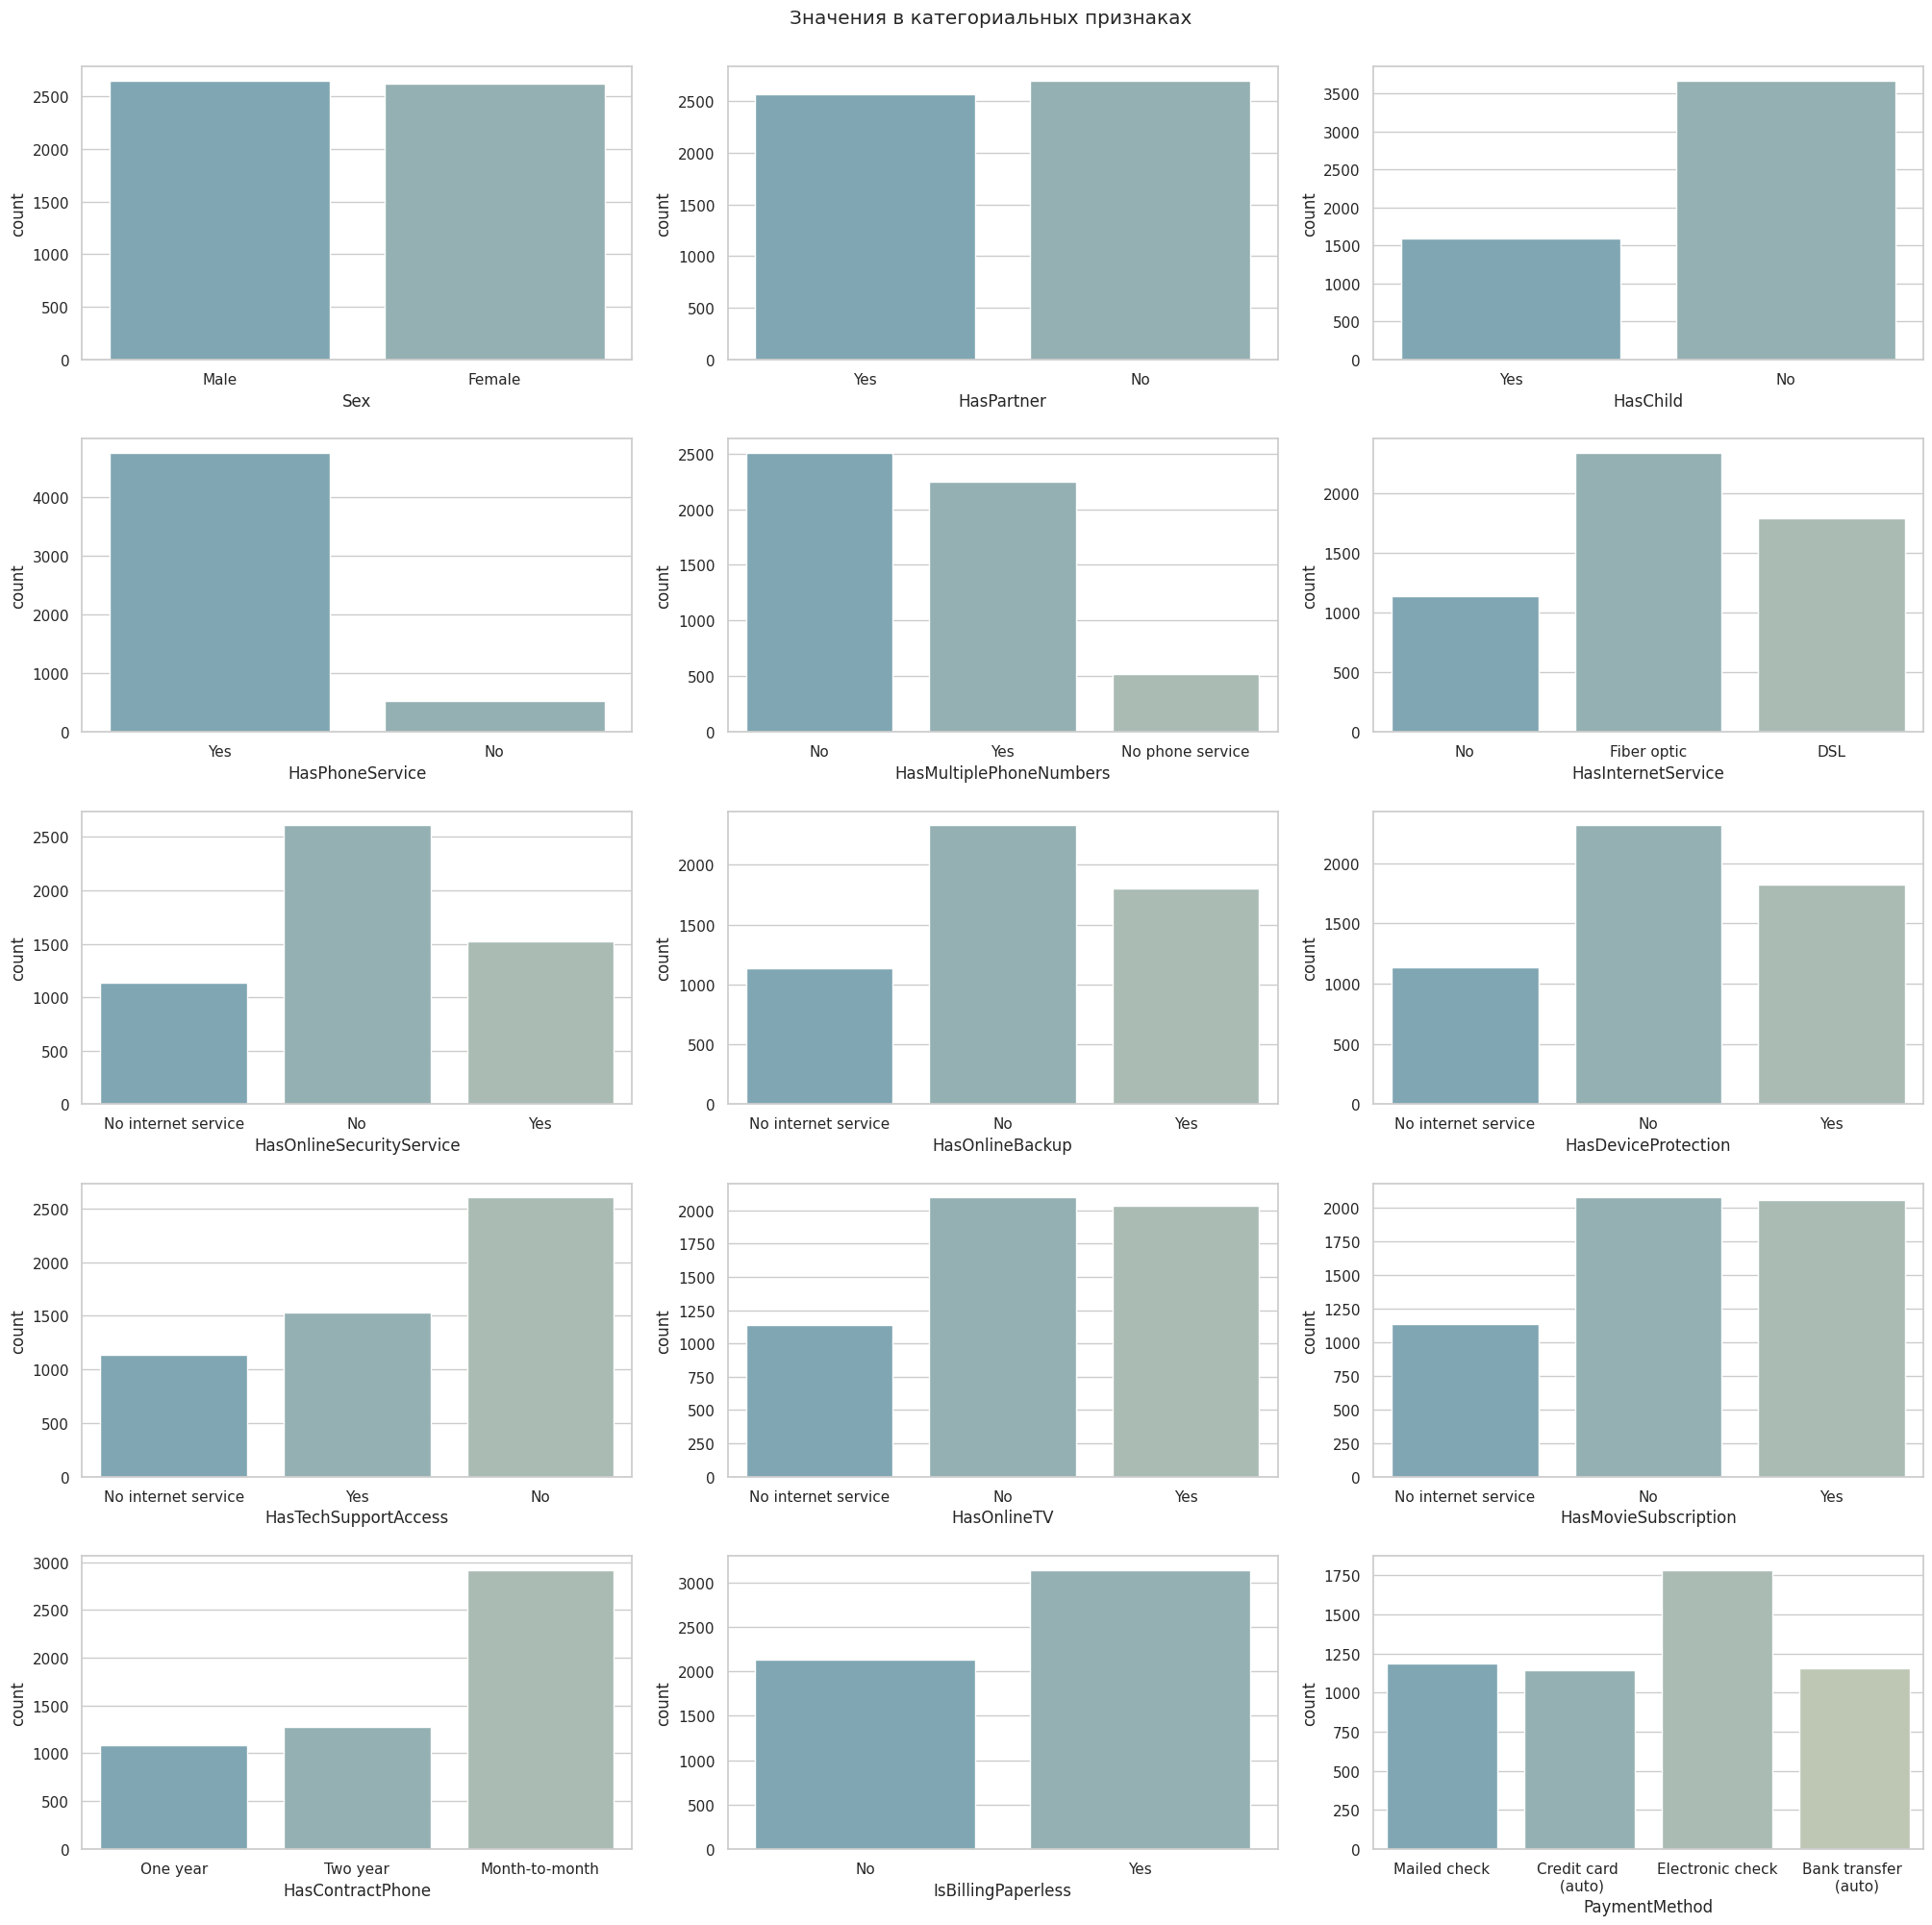

In [222]:
fig, ax = plt.subplots(5, 3, figsize=(20, 20))
ax = ax.flatten()
fig.suptitle('Значения в категориальных признаках')
fig.tight_layout(h_pad=3, w_pad=3)
plt.subplots_adjust(top=0.95)

sns.set_theme(style='whitegrid', palette="blend:#7AB,#EDA")
labels = ['Mailed check', 'Credit card \n (auto)', 'Electronic check', 'Bank transfer \n (auto)'] # labes для PaymentMethod
for i in range(len(categorical_columns)):
    sns.countplot(ax=ax[i], x=data_train[categorical_columns[i]])
    ax[14].set_xticklabels(labels)

In [223]:
data_train['HasContractPhone'].unique(), data_train['HasContractPhone'].value_counts()

(array(['One year', 'Two year', 'Month-to-month'], dtype=object),
 Month-to-month    2920
 Two year          1272
 One year          1081
 Name: HasContractPhone, dtype: int64)

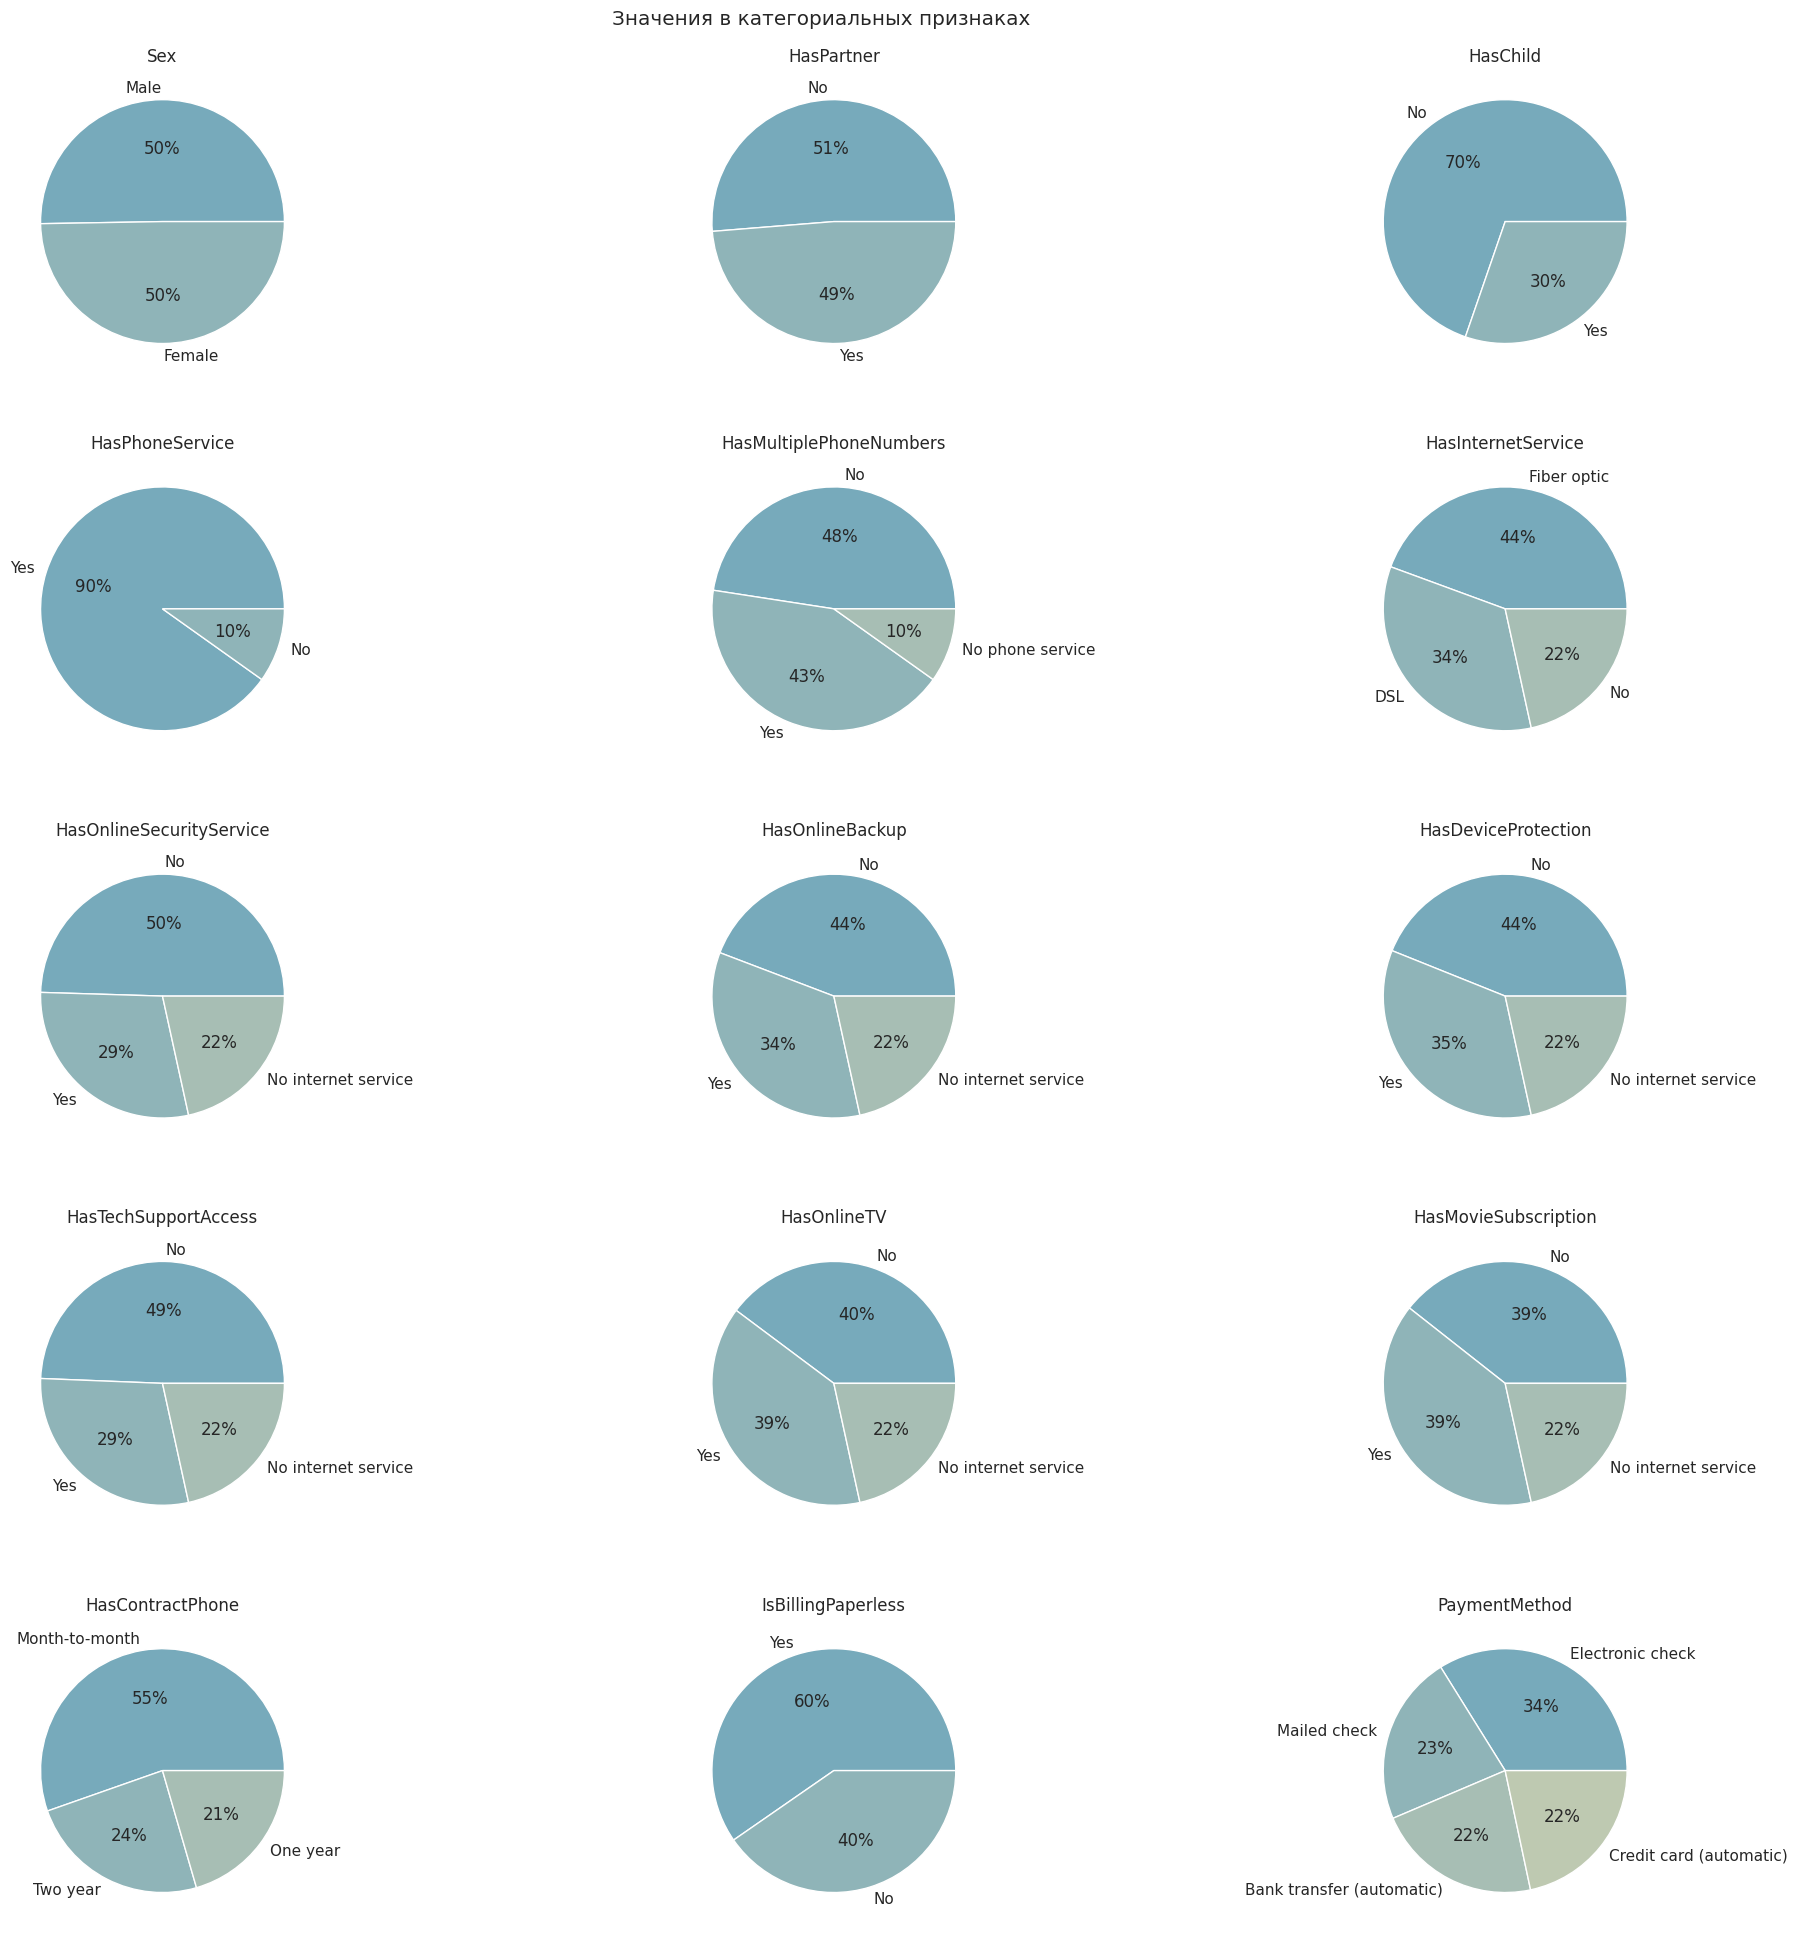

In [224]:
fig, ax = plt.subplots(5, 3, figsize=(20, 20))
ax = ax.flatten()
fig.suptitle('Значения в категориальных признаках')
fig.tight_layout(h_pad=3, w_pad=3)
plt.subplots_adjust(top=0.95)

sns.set_theme(style='whitegrid', palette="flare")
for i in range(len(categorical_columns)):
    data = data_train[categorical_columns[i]]
    ax[i].pie(x=data.value_counts(), labels=data.value_counts().index, autopct='%.0f%%')
    ax[i].set_title(categorical_columns[i])

<br>
<br>Сделаем попытку в нахождении выбросов</br>
<br>

In [225]:
data_train.describe()

,ClientPeriod,MonthlySpending,TotalSpent,IsSeniorCitizen,Churn
count,5273.000000,5273.000000,5273.000000,5273.000000,5273.000000
mean,32.452304,64.956770,2291.390461,0.159681,0.262469
std,24.534723,30.177911,2269.014233,0.366345,0.440018
min,1.000000,18.250000,18.800000,0.000000,0.000000
25%,9.000000,35.500000,401.100000,0.000000,0.000000
50%,29.000000,70.450000,1410.250000,0.000000,0.000000
75%,55.000000,90.050000,3807.350000,0.000000,1.000000
max,72.000000,118.750000,8684.800000,1.000000,1.000000


Стандратное отклонение у всех довольно большое, но TotalSpent самый подозрительный, во-первых, из-за того же std, во-вторых, из-за разницы в процентилях.<br>

<br>
<b>Проведем двумерный анализ и ,возможно, там найдем выборсы</b>
<br><br>

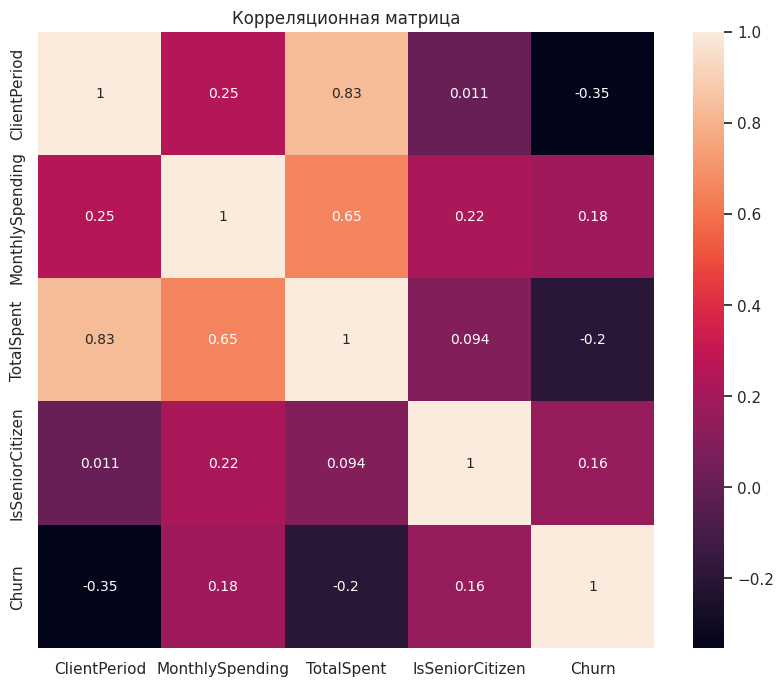

In [226]:
def corrmat(data: pd.DataFrame) -> None:
    """
       Построение корреляционной матрицы
       с коэффициентом корреляции Пирсона.
    """
    plt.figure(figsize=(10, 8))
    sns.heatmap(data.corr(), annot=True, square=True, annot_kws={'size': 10}).set_title('Корреляционная матрица')
    plt.show()
    
corrmat(data_train)

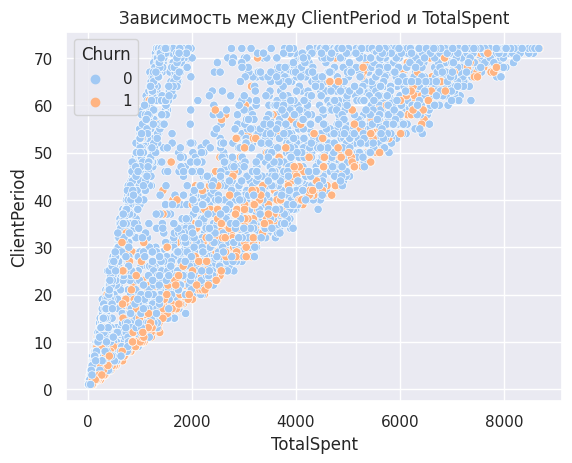

In [227]:
sns.set_theme(style='darkgrid', palette='pastel')
sns.scatterplot(x='TotalSpent', y='ClientPeriod', data=data_train, hue='Churn').set_title('Зависимость между ClientPeriod и TotalSpent')
plt.show()

График показывает:
 - Какое минимальное кол-во денег можно потратить за каждый день подписки
 - Какое максимальное кол-во денег можно потратить за каждый день подписки

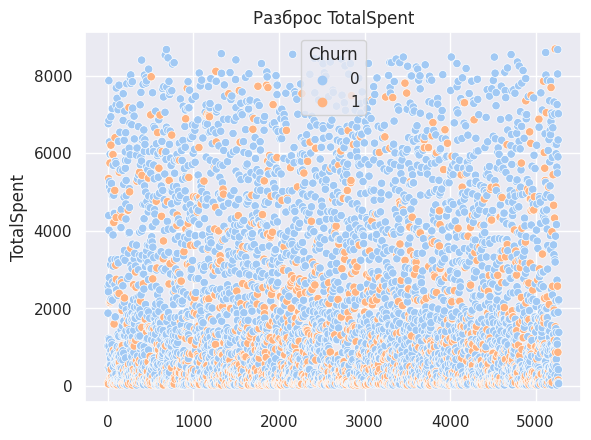

In [228]:
sns.set_theme(style='darkgrid', palette='pastel')
sns.scatterplot(x=range(data_train.TotalSpent.shape[0]), y='TotalSpent', data=data_train, hue='Churn').set_title('Разброс TotalSpent')
plt.show()

Выбросов не наблюдается

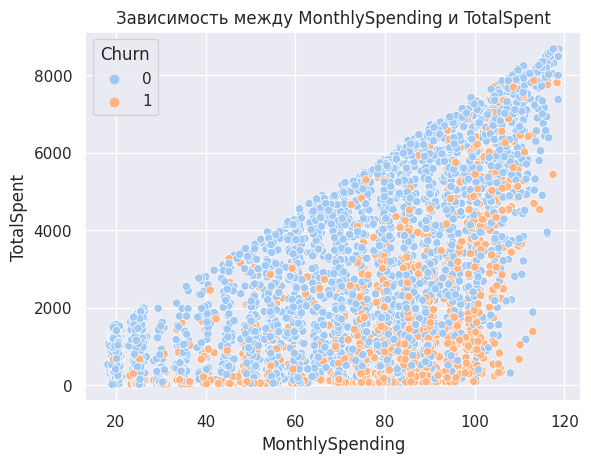

In [229]:
sns.set_theme(style='darkgrid', palette='pastel')
sns.scatterplot(x='MonthlySpending', y='TotalSpent', data=data_train, hue='Churn').set_title('Зависимость между MonthlySpending и TotalSpent')
plt.show()

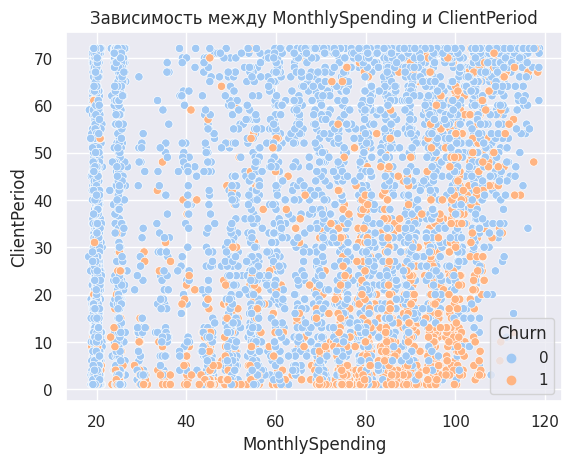

In [230]:
sns.set_theme(style='darkgrid', palette='pastel')
sns.scatterplot(x='MonthlySpending', y='ClientPeriod', data=data_train, hue='Churn').set_title('Зависимость между MonthlySpending и ClientPeriod')
plt.show()

<br>
<font size=6>Эпизод ⅠⅠ</font><br>
<br>
<font size=5>Линейные модели</font>
<hr>

<br>
<b>Предобработка данных</b>
<br><br>

In [231]:
data_train.head()

,ClientPeriod,MonthlySpending,TotalSpent,Sex,IsSeniorCitizen,HasPartner,HasChild,HasPhoneService,HasMultiplePhoneNumbers,HasInternetService,HasOnlineSecurityService,HasOnlineBackup,HasDeviceProtection,HasTechSupportAccess,HasOnlineTV,HasMovieSubscription,HasContractPhone,IsBillingPaperless,PaymentMethod,Churn
0,55,19.50,1026.35,Male,0,Yes,Yes,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,One year,No,Mailed check,0
1,72,25.85,1872.20,Male,0,Yes,No,Yes,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Credit card (automatic),0
2,1,75.90,75.90,Male,0,No,No,Yes,No,Fiber optic,No,No,No,Yes,No,No,Month-to-month,Yes,Electronic check,1
3,32,79.30,2570.00,Female,1,Yes,No,Yes,Yes,Fiber optic,No,No,Yes,No,No,No,Month-to-month,No,Mailed check,0
4,60,115.25,6758.45,Female,0,Yes,Yes,Yes,Yes,Fiber optic,Yes,Yes,Yes,Yes,Yes,Yes,Two year,No,Credit card (automatic),0


<br>
<b>Добавим новые признаки</b><br>
<br>

Первый признак, который мы добавим будет <b>probation - испытательный срок</b>.<br>
Когда мы простроили график распределения признака ClientPeriod, то поняли, что после примерно пяти дней, вероятность отказаться от услуг становится меньше.<br>
Исходя из этого, мы сделаем проверку на ClientPeriod > 5: 
 - 1 - Испытательный срок пройден
 - 0 - Испытательный срок не пройден

In [232]:
data_train['probation'] = (data_train.ClientPeriod > 5).map(lambda x: int(x))

По логике, чем больше человек пользуется нашими услугами, тем больше его TotalSpent, а если он пользуется нашими услугами долго, то следовательно вероятность, что он уйдет меньше.
Если посмотреть на график зависимости TotalSpent и ClientPeriod, то можно увидеть, что за условием TotalSpent > 4000 находится в основном класс 0.

    - data_train.loc[(data_train.TotalSpent > 4000) & (data_train.Churn == 0)].shape[0] = 1059 - класс 0
    - data_train.loc[(data_train.TotalSpent > 4000) & (data_train.Churn == 1)].shape[0] = 177 - класс 1

Основываясь на этом, мы добавим новый признак "donator", который будет нам говорить прошел ли человек платежный порог.

In [233]:
data_train['donator'] = (data_train.TotalSpent > 4000).map(lambda x: int(x))

К сожалению, к MonthlySpending такое решение не подойдет, на графиках видно, что тот, кто отказался от услуг мог платить как и большие суммы, так и маленькие.<br>
Но мы попробуем выжать еще немного из датасета, добавив новый признак по правилу:
 - MonthlySpending * TotalSpent

In [234]:
data_train['money merger'] = data_train.MonthlySpending * data_train.TotalSpent

Сделаем копию датасета, чтобы пользоваться ей в других моделях.

In [235]:
data_universal = data_train.copy()

Посмотрим, что изменилось в корреляционной матрице

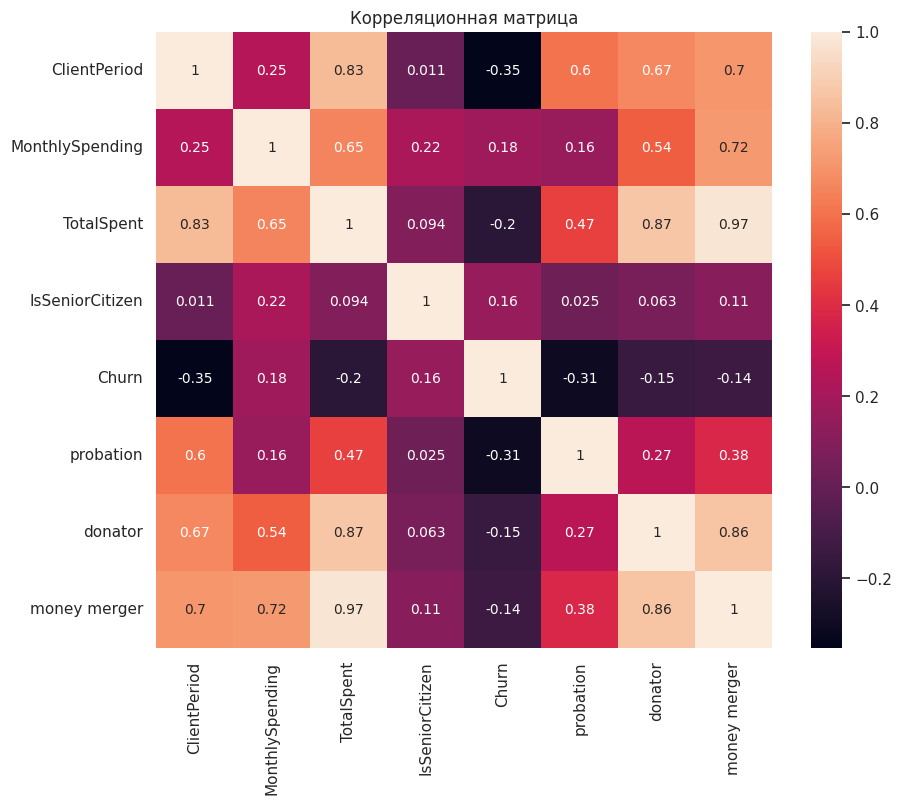

In [236]:
corrmat(data_train)

<br>
Соберем категориальные признаки еще раз<br>
<br>

In [237]:
categorical_columns = [col for col in data_train
                       if data_train[col].dtypes == 'object']

<br>
<i>Категориальные признаки</i> будем кодировать в два этапа:<br>
<br>
 1) LabelEncoder - превращаем строчки в числа<br>
 2) OneHotEncoder - превращаем полученные числа в one-hot вектора. Этот этап совместим с нормировко числовых признаков<br>
<br>

1) LabelEncoder.<br>

In [238]:
labelencoder = LabelEncoder()

def get_label_encoder(col: pd.Series) -> pd.Series:
    """
    :col param: принимает признак из датасета
    :return : возвращает закодированную серию,
              если входная была категориальной
    """
    if col.name in categorical_columns:
        return labelencoder.fit_transform(col)
    else:
        return col

In [239]:
data_train_encoder = data_train.apply(get_label_encoder) # кодируем категориальные признаки

2) OneHotEncoder и StandardScaler

In [240]:
numerical_columns = [col for col in data_train
                       if data_train[col].dtypes in ['int64', 'float64']]

     numerical_columns = ['ClientPeriod', 'MonthlySpending', 'TotalSpent', 'IsSeniorCitizen', 'Churn', 'probation', 'donator', 'money merger'] 
Избавимся от:
 - <b>'IsSeniorCitizen'</b>,  
 - <b>'Churn'</b>, 
 - <b>'probation'</b>
 - <b>'donator'</b>


In [241]:
numerical_columns = ['ClientPeriod', 'MonthlySpending', 'TotalSpent', 'money merger']

In [242]:
# предобработка числовых признаков
numerical_transformer = StandardScaler()

# предобработка категориальных признаков
categorical_transformer = OneHotEncoder()

# к категориальный признакам добавим probation, IsSeniorCitizen и donator
# так как по своему смыслу они тоже категориальные, поэтому пусть onehot раскидает их по датасету
categorical_columns.extend(['probation', 'IsSeniorCitizen', 'donator'])

# предобработка для категориальных и числовых признаков
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_columns),
        ('cat', categorical_transformer, categorical_columns)
    ]
)

<br>
<b>Объявление модели.</b>
<br><br>

In [243]:
model = LogisticRegression() # задаем без параметров

In [244]:
model_pipeline = Pipeline(
    steps=[
        ('preprocessor', preprocessor),
        ('model', model)
    ]
)

In [245]:
y = data_train_encoder.Churn # целевая переменная 
X = data_train_encoder.drop('Churn', axis=1) # набор данных без таргета

In [246]:
#from imblearn.over_sampling import RandomOverSampler

In [247]:
#over = RandomOverSampler()
#X, y = over.fit_resample(X, y)

<br>
<b>Поиск параметров для логистической регрессии</b>
<br><br>

In [248]:
%%time
# Будем проверять параметр регуляризации C и кол-во итераций
logreg_params = {
    'model__C': [100, 10, 1, 0.1, 0.01, 0.001],
    'model__max_iter': [50, 100, 300, 500]
}
    

logreg_search = GridSearchCV(model_pipeline,
                             param_grid=logreg_params,
                             cv=5,
                             scoring='roc_auc')

logreg_search.fit(X, y)

CPU times: user 27.5 s, sys: 18.7 s, total: 46.2 s
Wall time: 12.7 s


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         StandardScaler(),
                                                                         ['ClientPeriod',
                                                                          'MonthlySpending',
                                                                          'TotalSpent',
                                                                          'money '
                                                                          'merger']),
                                                                        ('cat',
                                                                         OneHotEncoder(),
                                                                         ['Sex',
                                                                          'HasPartner',
                                                                          'HasChild',
                                                                          'HasPhoneService',
                                                                          'HasMultiplePhoneNumbers',
                                                                          'HasInternetService',
                                                                          'HasOnlineSecurityService',
                                                                          'HasOnlineBackup',
                                                                          'HasDeviceProtection',
                                                                          'HasTechSupportAccess',
                                                                          'HasOnlineTV',
                                                                          'HasMovieSubscription',
                                                                          'HasContractPhone',
                                                                          'IsBillingPaperless',
                                                                          'PaymentMethod',
                                                                          'probation',
                                                                          'IsSeniorCitizen',
                                                                          'donator'])])),
                                       ('model', LogisticRegression())]),
             param_grid={'model__C': [100, 10, 1, 0.1, 0.01, 0.001],
                         'model__max_iter': [50, 100, 300, 500]},
             scoring='roc_auc')

Лучшие параметры модели

In [249]:
print(f'Лучшие параметры: {logreg_search.best_params_}')
print(f'Лучшая метрика: {logreg_search.best_score_}')
print(f'Лучшая модель: {logreg_search.best_estimator_}')

Лучшие параметры: {'model__C': 0.1, 'model__max_iter': 100}
Лучшая метрика: 0.8471104678483954
Лучшая модель: Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['ClientPeriod',
                                                   'MonthlySpending',
                                                   'TotalSpent',
                                                   'money merger']),
                                                 ('cat', OneHotEncoder(),
                                                  ['Sex', 'HasPartner',
                                                   'HasChild',
                                                   'HasPhoneService',
                                                   'HasMultiplePhoneNumbers',
                                                   'HasInternetService',
                                                   'HasOnlineSecurityService',
  

<br>
Посмотрим на график roc_auc<br>
<br>

In [250]:
def draw_auc_train(y: pd.Series, y_train_predicted: np.array) -> None:
    """Функция принимает серию ответов и массив предсказаний
       После считает roc_auc и строит график"""
    train_auc = roc_auc_score(y, y_train_predicted)
    
    plt.figure(figsize=(8,6))
    plt.plot(*roc_curve(y, y_train_predicted)[:2], label='train AUC={:.4f}'.format(train_auc))
    legend_box = plt.legend(fontsize='large', framealpha=1).get_frame()
    legend_box.set_facecolor("white")
    legend_box.set_edgecolor("black")
    plt.plot(np.linspace(0,1,100), np.linspace(0,1,100))
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.show()

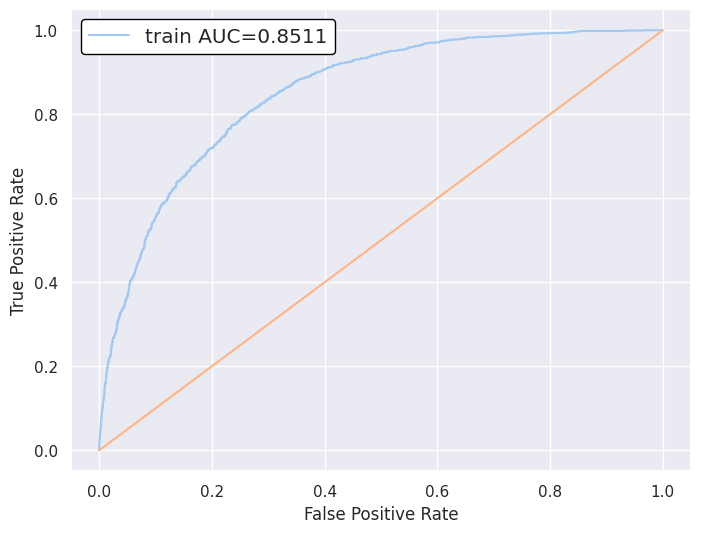

In [251]:
y_train_predicted = logreg_search.predict_proba(X)[:, 1] # получаем предсказания для всего датасета X
draw_auc_train(y, y_train_predicted) # рисуем roc_auc график

<br>

<b>МЕТРИКА МОДЕЛИ LogisticRegression</b>:
 - С дефолтными признаками: 0.83 (Grid) train_auc = 0.8482.
 - C дополнительными признаками: 0.84 (Grid) train_auc = 0.8511
<br>
<br>

<br>
<font size=6>Эпизод ⅠⅠⅠ</font><br>
<br>
<font size=5>Random Forest</font>
<hr>

In [252]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import roc_auc_score
from tqdm.notebook import tqdm
from imblearn.over_sampling import RandomOverSampler

In [253]:
X_train = data_universal.drop('Churn', axis=1)
y_train = data_universal.Churn

<br>
Кодируем категориальные признаки<br>
<br>

In [254]:
X_train = pd.get_dummies(X_train)

<br>
Применяем OverSampler для устранения дисбаланса целевого признака<br>
<br>

In [255]:
over = RandomOverSampler()
X_train, y_train = over.fit_resample(X_train, y_train)

<br>
<b>Поиск параметров для Random Forest</b>
<br><br>

Искать будем <b>max_trees</b><br> 
<br>
<b>max_depth</b> - найдем вручную.

In [271]:
max_trees = 100
values = np.arange(max_trees) + 1
kf = KFold(n_splits=5, shuffle=True, random_state=1234)
# global_scores = []
number_kf = 0
best_trees = []

for train_indices, test_indices in tqdm(kf.split(X_train), total=5, desc=f'Processing KFold'):
    number_kf += 1
    scores = []
    
    X_train_kf = X_train.iloc[train_indices]
    y_train_kf = y_train.iloc[train_indices]
    
    X_test_kf = X_train.iloc[test_indices]
    y_test_kf = y_train.iloc[test_indices]
    
    forest = RandomForestClassifier(n_estimators=max_trees, max_depth=20)
    forest.fit(X_train_kf, y_train_kf)
    trees = forest.estimators_
    
    for number_of_trees in tqdm(values, leave=False, desc=f'Processing number_of_trees'):
        thinned_forest = RandomForestClassifier(n_estimators=number_of_trees)
        
        thinned_forest.n_classes_ = 2
        thinned_forest.estimators_ = trees[:number_of_trees]
        predict = thinned_forest.predict_proba(X_test_kf)[:, 1]
        scores.append((roc_auc_score(y_test_kf, predict), number_of_trees))
        
    scores = np.array(scores)
    max_roc_auc = scores[:, 0].max()
    for index, number_of_trees in enumerate(scores[:, 1]):
        if scores[index, 0] == max_roc_auc:
            best_trees.append(number_of_trees)
            print('-'*30)
            print(f'Номер kf = {number_kf}')
            print(f'trees = {number_of_trees}, max roc auc = {round(max_roc_auc, 4)}')
            print('-'*30)
        
#     global_scores.append(scores)
    
# global_scores = np.stack(global_scores, axis=0)   

Processing KFold:   0%|          | 0/5 [00:00<?, ?it/s]

Processing number_of_trees:   0%|          | 0/100 [00:00<?, ?it/s]

------------------------------
Номер kf = 1
trees = 83.0, max roc auc = 0.966
------------------------------


Processing number_of_trees:   0%|          | 0/100 [00:00<?, ?it/s]

------------------------------
Номер kf = 2
trees = 98.0, max roc auc = 0.9703
------------------------------


Processing number_of_trees:   0%|          | 0/100 [00:00<?, ?it/s]

------------------------------
Номер kf = 3
trees = 92.0, max roc auc = 0.9636
------------------------------


Processing number_of_trees:   0%|          | 0/100 [00:00<?, ?it/s]

------------------------------
Номер kf = 4
trees = 81.0, max roc auc = 0.972
------------------------------


Processing number_of_trees:   0%|          | 0/100 [00:00<?, ?it/s]

------------------------------
Номер kf = 5
trees = 81.0, max roc auc = 0.9666
------------------------------


In [272]:
# возьмем среднее число по лучшему параметру max_trees
trees = np.mean(best_trees, dtype='int64')
# объявление модели в лучшим параметром n_estimators
model = RandomForestClassifier(n_estimators=trees, max_depth=20)

In [273]:
%%time
model.fit(X_train, y_train)

CPU times: user 934 ms, sys: 9.65 ms, total: 944 ms
Wall time: 947 ms


RandomForestClassifier(max_depth=20, n_estimators=87)

TO DO LIST:
 - Применить стекинг
 - Применить бустинг: XGBOOST, CATBOOST